## EWMA&SW Validation

In [1]:
%reset -f
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

In [3]:
#Parameters for EWMA&SW test
p = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #Bernoulli Parameters
# p = np.array([.95, .90, .80, .65, .45, .25, .15, .10])
# p = np.array([.90, .80, .70, .55, .45, .35, .20, .10])
rate = np.array([6, 9, 12, 18, 24, 36, 48, 54])
tp = np.multiply(p,rate)

K= p.shape[0] #Number of branches
delta= ( np.ones(K)*np.max(tp) ) - tp

T= 5000 #Time periods
runs = 1 #Number of iterations

print("Pi:",p)
print("delta:",delta)

Pi: [0.99 0.98 0.96 0.93 0.9  0.1  0.06 0.04]
delta: [15.66 12.78 10.08  4.86  0.   18.   18.72 19.44]


## KL-UCB EWMA & SW

In [4]:
%%capture
ewma = kl_ucb_policy.KLUCB_EWMA(K, rate, 500, 0.2) #Optimal Graphical OptimalRate Sampling
total_rewards_list_ewma = np.zeros((runs, T))
actions_list_ewma = []
sw = kl_ucb_policy.GORS_SW(K, rate, 500) #Original KL UCB
total_rewards_list_sw = np.zeros((runs, T))
actions_list_sw = []
start_time = time.time()

for run in range(runs):
    ewma.reset()
    actions_ewma = np.zeros((K, T), dtype=np.int)
    rewards_ewma = np.zeros((K, T), dtype=np.float)
    sw.reset()
    actions_sw = np.zeros((K, T), dtype=np.int)
    rewards_sw = np.zeros((K, T), dtype=np.float)
    for t in range(T):
        # print('at time slot: ', t)
        arm_ewma = ewma.select_next_arm()
        actions_ewma[arm_ewma, t] = 1
        rewards_ewma[arm_ewma, t] = np.random.binomial(1, p[arm_ewma]) * rate[arm_ewma]
        ewma.update_state(arm_ewma, rewards_ewma[arm_ewma, t] / rate[arm_ewma])

        arm_sw = sw.select_next_arm()
        actions_sw[arm_sw, t] = 1
        rewards_sw[arm_sw, t] = np.random.binomial(1, p[arm_sw]) * rate[arm_sw]
        sw.update_state(arm_sw, rewards_sw[arm_sw, t] / rate[arm_sw])
        # print('N is:',ewma.N)
        # print('S is:',ewma.S)
        # print('l is:',ewma.l)
        # print('L is:',ewma.L)
    cumulative_rewards_ewma = np.cumsum(rewards_ewma, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_ewma = np.sum(cumulative_rewards_ewma, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_ewma[run, :] = np.copy(total_rewards_ewma)
    actions_list_ewma.append(np.copy(actions_ewma))

    cumulative_rewards_sw = np.cumsum(rewards_sw, axis=1)
    total_rewards_sw = np.sum(cumulative_rewards_sw, axis=0)
    total_rewards_list_sw[run, :] = np.copy(total_rewards_sw)
    actions_list_sw.append(np.copy(actions_sw))

time_spent = time.time() - start_time

## Results

In [5]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

Time for KL-UCB (Newton), with T = 5000 , runs = 1 : 3.8719797134399414 seconds


In [6]:
mean_total_rewards_ewma = np.mean(total_rewards_list_ewma, axis=0)
mean_total_rewards_sw = np.mean(total_rewards_list_sw, axis=0)
print("t & Reward (total) G-ORS :", t, mean_total_rewards_ewma[t])
print("t & Reward (total) KL-UCB :", t, mean_total_rewards_sw[t])

t & Reward (total) G-ORS : 4999 104604.0
t & Reward (total) KL-UCB : 4999 105366.0


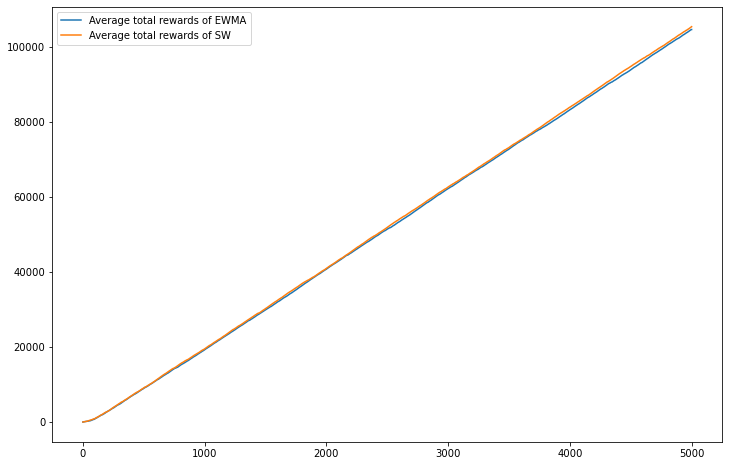

In [7]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(mean_total_rewards_ewma[:], linestyle='-', label='Average total rewards of EWMA')
ax1.plot(mean_total_rewards_sw[:], linestyle='-', label='Average total rewards of SW')
ax1.legend(loc='best')
plt.show()

In [8]:
#Regrets calculation for EWMA
total_action_ewma = np.zeros((K, T))
for actions_ewma in actions_list_ewma:
    total_action_ewma += np.cumsum(actions_ewma, axis=1) #The cumulative times of each arm to be selected
total_action_ewma = total_action_ewma / runs
regret_cumule_ewma = np.dot(delta, total_action_ewma[:, :]) # Cumulative regrets
#Regrest calculation for Sliding Window
total_action_sw = np.zeros((K, T))
for actions_sw in actions_list_sw:
    total_action_sw += np.cumsum(actions_sw, axis=1) #The cumulative times of each arm to be selected
total_action_sw = total_action_sw / runs
regret_cumule_klucb = np.dot(delta, total_action_sw[:, :]) # Cumulative regrets

## Average cumulative regrets

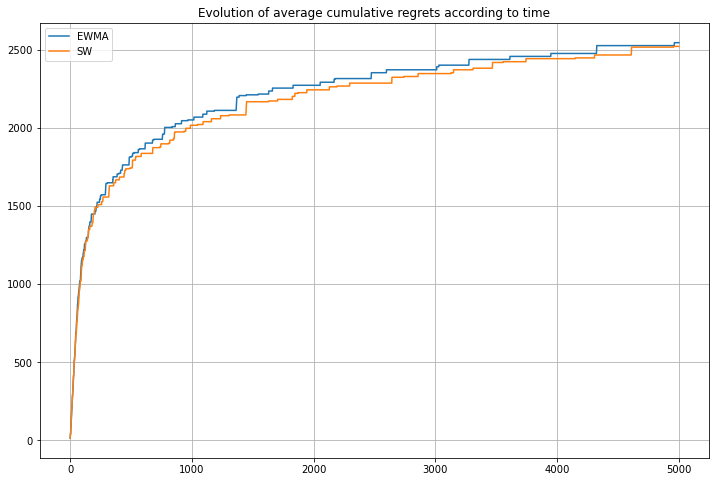

In [9]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_ewma[:], linestyle='-', label='EWMA')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='SW')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
plt.show()

In [10]:
T0 = 4999
#G-ORS
distribution_regret_gors = []
distribution_regret_klucb = []
for actions_ewma in actions_list_ewma:
    distribution_regret_gors.append(np.dot(delta, np.sum(actions_ewma[:, :T0], axis=1)))
for actions_sw in actions_list_sw:
    distribution_regret_klucb.append(np.dot(delta, np.sum(actions_sw[:, :T0], axis=1)))

## Boxplot of average regret

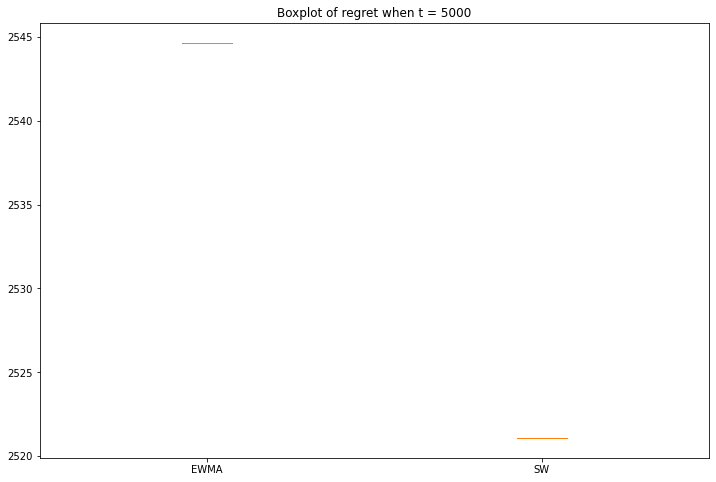

In [11]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_gors,
        distribution_regret_klucb
    ])
ax.set_xticklabels([
        'EWMA',
        'SW'
    ])

ax.set_title('Boxplot of regret when t = 5000')
plt.show()